In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import os
import folium
import alphashape
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.animation as animation
import imageio
import networkx as nx
import io
from PIL import Image
import time
import sys
from matplotlib import cm
from IPython.display import clear_output
import seaborn as sns
import matplotlib.colors as mcolors
pd.options.mode.copy_on_write = True

%matplotlib inline

In [71]:
class Network:
    def __init__(self, crs = 32618):
        self.crs = crs
        self.n_pot = None
        self.n_pot_og = None
        self.n_pot_nodes = None
        self.n_pot_edges = None
        self.n_ex = None
        self.n_ex_og = None
        self.n_ex_nodes = None
        self.n_ex_edges = None
        self.trips = None
        self.map_pot = None
        self.map_ex = None
        self.map_routes = None
        self.trips = None
        self.trips_within = None
        self.sample = None
        self.boundaries = None
        self.routes = []
        self.unsolved_routes_ids = []
        self.all_routes_edges = None
        self.routes_summary = None
        self.evol = []
        
    def load_n_pot(self,path):
        self.n_pot = ox.io.load_graphml(path)
        self.n_pot = ox.project_graph(self.n_pot)
        self.n_pot_nodes,self.n_pot_edges = ox.graph_to_gdfs(self.n_pot)
        cols = self.n_pot_nodes.columns
        self.n_pot_nodes = self.n_pot_nodes.sjoin(self.n_pot_edges,predicate = 'intersects', lsuffix = None)
        self.n_pot_nodes = self.n_pot_nodes[cols]
        self.n_pot_nodes = self.n_pot_nodes.drop_duplicates()
        self.n_pot_edges['build_iter'] = 0
        self.n_pot_og = ox.graph_from_gdfs(self.n_pot_nodes.copy(),self.n_pot_edges.copy())
        
    def filter_n_pot(self):
        self.n_pot_edges[self.n_pot_eges.highway.isin(['residential','primary','secondary','tertiary','tertiary_link'])]
        self.n_pot = ox.graph_from_gdfs(self.n_pot_nodes,self.n_pot_edges)

    def plot_n_pot(self, nodes = False):
        if self.n_pot == None:
            print('No potential network loaded')
        else:
            self.map_pot = self.n_pot_edges.explore(color = 'black')
            if nodes:
                self.n_pot_nodes.explore(m = self.map_pot)
            display(self.map_pot)

    def load_n_ex(self,path):
        self.n_ex = ox.io.load_graphml(path)
        self.n_ex = ox.project_graph(self.n_ex)
        self.n_ex_nodes,self.n_ex_edges = ox.graph_to_gdfs(self.n_ex)
        cols = self.n_ex_nodes.columns
        self.n_ex_nodes = self.n_ex_nodes.sjoin(self.n_ex_edges,predicate = 'intersects', lsuffix = None)
        self.n_ex_nodes = self.n_ex_nodes[cols]
        self.n_ex_nodes = self.n_ex_nodes.drop_duplicates()
        self.n_ex_edges['build_iter'] = 0
        self.n_ex_og = ox.graph_from_gdfs(self.n_ex_nodes.copy(),self.n_ex_edges.copy())

    def filter_n_ex(self,highway_type = 'cycleway'):
        self.n_ex_edges = self.n_ex_edges[self.n_ex_edges.highway == highway_type]
        self.n_ex = ox.graph_from_gdfs(self.n_ex_nodes,self.n_ex_edges)

    def plot_n_ex(self, nodes = False):
        if self.n_ex == None:
            print('No existing network loaded')
        else:
            self.map_ex = self.n_ex_edges.explore(color = 'black')
            if nodes:
                self.n_ex_nodes.explore(m = self.map_ex)
            display(self.map_ex)

    def load_trips(self, path, cols = ['ipere','mode','motif','age','xorig','yorig','xdest','ydest','potVelo','fexpPotVelo', 'velo'],potvel = True):
        self.trips = pd.read_csv(path)
        if potvel == True:
            self.trips = self.trips[self.trips.potVelo == 1]
        self.trips = self.trips[cols]
        self.trips = gpd.GeoDataFrame(self.trips, geometry=gpd.points_from_xy(self.trips.xorig, self.trips.yorig), crs=32188)
        self.trips = self.trips.rename(columns = {'geometry': 'orig'})
        self.trips = self.trips.assign(dest = gpd.points_from_xy(self.trips.xdest, self.trips.ydest,crs=32188))
        self.trips = self.trips.set_geometry('orig')
        self.trips = self.trips.to_crs(self.crs)
        self.boundaries = gpd.GeoDataFrame({'name':['region']},geometry = gpd.GeoSeries(self.n_pot_edges.geometry.union_all()).concave_hull(0.2)
                                           , crs = self.crs)
        
        self.trips = self.trips.to_crs(self.crs)
        self.trips.index+=1
        self.trips_within = gpd.sjoin(self.trips, self.boundaries, how='inner', predicate='within')[list(self.trips.columns)]
        self.trips_within = self.trips_within.set_geometry('dest')
        self.trips_within = self.trips_within.to_crs(self.crs)
        self.trips_within = gpd.sjoin(self.trips_within, self.boundaries, how='inner', predicate='within')[list(self.trips.columns)]
        


    def sample_trips(self,sample_size = None, spec_route = None):
        if sample_size is None:
            sample_size = len(self.trips_within)
            self.sample = self.trips_within.sample(sample_size)
        else:
            self.sample = pd.concat([self.sample,self.trips_within.sample(sample_size)])
        if spec_route is not None:
            self.sample = self.trips_within[self.trips_within.ipere == spec_route]

    def compute_routes(self, network, weight = 'gencost'):
        network = ox.projection.project_graph(network, to_crs = self.crs)
        o_nodes,o_dists = ox.nearest_nodes(network,self.sample.orig.x.values,self.sample.orig.y.values, return_dist=True)
        d_nodes,d_dists = ox.nearest_nodes(network,self.sample.dest.x.values,self.sample.dest.y.values, return_dist=True)
        routes = ox.shortest_path(network, o_nodes, d_nodes, weight=weight,cpus = None)
        self.routes+=routes

    
    def reset_sample(self):
        self.sample = None
    def reset_routes(self):
        self.routes = []
        self.unsolved_routes_ids = []
        self.all_routes_edges = None
        self.routes_summary = None
        
    def get_routes_edges(self,network):
        route_edges = []
        static_route_ids = []
        for i in tqdm(range(len(self.routes)),leave = False):
            if self.routes[i] is not None:
                if len(self.routes[i])>1:
                    edges = ox.routing.route_to_gdf(network,self.routes[i])
                    edges['route_number'] = self.sample.index[i]
                    route_edges.append(edges) 
                else:
                    static_route_ids.append(self.sample.index[i])
            
            else:
                self.unsolved_routes_ids.append(self.sample.index[i])
                continue
        print((1-len(self.unsolved_routes_ids)/len(self.sample))*100,'% of solved routes, ',len(static_route_ids)/len(self.sample)*100,
        ' % of static routes')
        self.sample = self.sample.drop(self.unsolved_routes_ids)
        self.sample = self.sample.drop(static_route_ids)
        self.all_routes_edges = pd.concat(route_edges)
    
    def compute_routes_summary(self):
        
        self.routes_summary = self.all_routes_edges[['length','gencost','route_number']].groupby(['route_number']).sum()
        self.routes_summary['length_cycleway'] = self.all_routes_edges.groupby('route_number').apply(
            lambda x: x.loc[x["highway"] == "cycleway", "length"].sum(),include_groups=False)
        self.routes_summary['length_street'] = self.all_routes_edges.groupby('route_number').apply(
            lambda x: x.loc[x["highway"] != "cycleway", "length"].sum(),include_groups=False)
        self.routes_summary['prop_cycleway'] = self.routes_summary['length_cycleway']/self.routes_summary['length']

        # links = self.all_routes_edges[self.all_routes_edges.highway !='cycleway'].drop_duplicates()
        # flows = self.all_routes_edges[self.all_routes_edges.highway !='cycleway'].groupby(by = ['length'], as_index = False).size()['size']
        # links['flow'] = flows.values
        # links['flux'] = flows.values*links.length

    def plot_routes(self,network):

        if self.all_routes_edges is None:
            self.get_routes_edges(network)
        

        self.sample = self.sample.set_geometry('orig')
        self.map_routes = self.sample.explore(color='blue', name='orig')
        self.sample = self.sample.set_geometry('dest')
        map2 = self.sample.explore(color='red', name='dest', m=self.map_routes)
        map3 = self.boundaries.explore(m = self.map_routes, name = 'boundaries', fill = False)
        map4 = self.n_ex_edges.explore(color='black', name='existing', m=self.map_routes,style_kwds={'opacity': 0.3})
        map5 = self.n_pot_edges.explore(color='black', name='potential', m=self.map_routes,style_kwds={'opacity': 0.3})
        self.all_routes_edges['route_n'] = self.all_routes_edges['route_number'].astype(str)
        map8 = self.all_routes_edges.explore(column = 'route_n',cmap = 'gist_rainbow', name = 'routes', m = self.map_routes, legend = False
                                            ,style_kwds={'weight': 5})
        folium.LayerControl().add_to(self.map_routes)
        display(self.map_routes)

    def weight_network(self,cycleway_reduc_factor=0.9):
        self.n_pot_edges['gencost'] = self.n_pot_edges["length"] * self.n_pot_edges["highway"].apply(
            lambda x: cycleway_reduc_factor if x == "cycleway" else 1)
        self.n_pot = ox.graph_from_gdfs(self.n_pot_nodes,self.n_pot_edges)


    def compute_routes_replace(self,network,idxs,weight = 'gencost'):
        network = ox.projection.project_graph(network, to_crs = self.crs)
        subsample = self.sample.loc[idxs]
        o_nodes,o_dists = ox.nearest_nodes(network,subsample.orig.x.values,subsample.orig.y.values, return_dist=True)
        d_nodes,d_dists = ox.nearest_nodes(network,subsample.dest.x.values,subsample.dest.y.values, return_dist=True)
        routes = ox.shortest_path(network, o_nodes, d_nodes, weight=weight)
        route_edges = []
        for i in range(len(idxs)):
                if routes[i] is not None:
                    if len(routes[i])>1:
                        edges = ox.routing.route_to_gdf(network,routes[i])
                        edges['route_number'] = idxs[i]
                        route_edges.append(edges)
        newroutes = pd.concat(route_edges)
        self.all_routes_edges = self.all_routes_edges[~self.all_routes_edges['route_number'].isin(idxs)]
        self.all_routes_edges = pd.concat([self.all_routes_edges,newroutes])
        
    def run_algo(self,n_iter = 1000, budget = 10000):
        self.reset_routes()
        self.compute_routes(self.n_pot)
        self.get_routes_edges(self.n_pot)
 
        for i in tqdm(range(n_iter)):
            clear_output(wait = True)
            self.compute_routes_summary()
            preconnected = self.routes_summary[(self.routes_summary['length_cycleway']>0)&(self.routes_summary['length_street']>0)]
            route_id_to_add = preconnected[preconnected['length_street'] == preconnected['length_street'].min()].index[0]
            print('adding ',route_id_to_add)
            route_edges = self.all_routes_edges[self.all_routes_edges.route_number == int(route_id_to_add)]
            route_edges_to_add = route_edges[route_edges.highway!='cycleway']
    
            edges_id_to_add = route_edges_to_add.index
            self.n_pot_edges.loc[edges_id_to_add,'highway']='cycleway'
            self.n_pot_edges.loc[edges_id_to_add,'build_iter'] = np.max(self.n_pot_edges.build_iter)+1
            self.n_ex_edges = self.n_pot_edges[self.n_pot_edges.highway == 'cycleway']
    
            self.weight_network()
            self.n_pot = ox.graph_from_gdfs(self.n_pot_nodes,self.n_pot_edges)
    
            recompute_polygon = route_edges.buffer(500).union_all()
            recompute_polygon = gpd.GeoDataFrame([recompute_polygon]).rename(columns={0:'geometry'}).set_geometry('geometry')
            recompute_polygon = recompute_polygon.set_crs(self.crs)
            
            o_int = recompute_polygon.sjoin(self.sample.set_geometry('orig')).index_right.tolist()
            d_int = recompute_polygon.sjoin(self.sample.set_geometry('dest')).index_right.tolist()
    
            recompute_idxs = list(set(o_int+d_int))

            m = recompute_polygon.explore()
            self.sample.loc[o_int].explore(m = m, color = 'yellow')
            display(m)
            break
    
            if len(recompute_idxs) == 0:
                continue
            else:
                print('recomputing ',len(recompute_idxs))
                self.compute_routes_replace(self.n_pot,recompute_idxs)
            

In [72]:
n = Network()
ex = 'Data/Reseaux/ns_EX_Rosemont-la-Petite-Patrie+Villeray-Saint-Michel-Parc-Extension+Le-Plateau-Mont-Royal.graphml'
pot = 'Data/Reseaux/ns_POT_Rosemont-la-Petite-Patrie+Villeray-Saint-Michel-Parc-Extension+Le-Plateau-Mont-Royal.graphml'
# ex = 'Data/Reseaux/ns_EX_Outremont.graphml'
# pot = 'Data/Reseaux/ns_POT_Outremont.graphml'
trips = 'Data/od18_extraqit_20250123/od18_extraqit_20250123.csv'

In [73]:
n.load_n_pot(pot)
n.load_n_ex(ex)
n.load_trips(trips)

In [74]:
def funcToMethod(func, clas, method_name=None):
    setattr(clas, method_name or func.__name__, func)
def run_algo(self,n_iter = 1000, budget = 10000,plot = True):
    if np.max(self.n_pot_edges.build_iter) == 0:
        self.reset_routes()
        self.evol = []
        self.compute_routes(self.n_pot)
        self.get_routes_edges(self.n_pot)
        self.compute_routes_summary()
        self.evol.append(self.routes_summary.copy().prop_cycleway)
    for i in tqdm(range(n_iter), desc = 'Algo running'):
        if plot:
            if i==0:
                fig, ax = plt.subplots(figsize = (5,5))
                ax.axis('off')
        #clear_output(wait = True)
        #print(f'Iteration {i}')
        preconnected = self.routes_summary[(self.routes_summary['length_cycleway']>0)&(self.routes_summary['length_street']>0)]
        if len(preconnected) == 0 and i<len(self.sample):
            preconnected = self.routes_summary[(self.routes_summary['length_street']>0)]
        route_id_to_add = preconnected.sort_values(by = 'fpkm', ascending = False).index[0]
        recompute_summary_idxs = preconnected.sort_values(by = 'fpkm', ascending = False).index[:len(self.routes_summary)//10+1].tolist()
        
        
        #print('adding ',route_id_to_add, ' with ',preconnected['fpkm'].max(), 'flow/km')
        route_edges = self.all_routes_edges[self.all_routes_edges.route_number == int(route_id_to_add)]
        route_edges_to_add = route_edges[route_edges.highway!='cycleway']

        edges_id_to_add = route_edges_to_add.index
        self.n_pot_edges.loc[edges_id_to_add,'highway']='cycleway'
        self.n_pot_edges.loc[edges_id_to_add,'build_iter'] = np.max(self.n_pot_edges.build_iter)+1
        self.n_ex_edges = self.n_pot_edges[self.n_pot_edges.highway == 'cycleway']
        self.all_routes_edges.loc[edges_id_to_add,'highway']='cycleway'

        self.compute_routes_summary(subsample_idxs = recompute_summary_idxs)
        self.evol.append(self.routes_summary.copy().prop_cycleway)
        if plot:
            if i%5== 0:
                
                n.n_ex_edges[n.n_ex_edges.build_iter<=i].plot(column = 'build_iter',cmap = 'viridis',ax=ax)
                clear_output(wait = True)
                display(fig)
                print(f'Iteration {i}/{n_iter}')

        #display(self.routes_summary.head())
        # # self.weight_network()
        # # self.n_pot = ox.graph_from_gdfs(self.n_pot_nodes,self.n_pot_edges)

        # recompute_polygon = route_edges_to_add.buffer(10).union_all()
        # recompute_polygon = gpd.GeoDataFrame([recompute_polygon]).rename(columns={0:'geometry'}).set_geometry('geometry')
        # recompute_polygon = recompute_polygon.set_crs(self.crs)
        
        # # routes_int = recompute_polygon.sjoin(self.all_routes_edges).route_number.tolist()
        # edges_int_idxs = self.all_routes_edges.sjoin(recompute_polygon, how = 'right',predicate = 'within', lsuffix = None).set_index(['u', 'v', 'key']).index
        # m = recompute_polygon.explore()
        # self.all_routes_edges.loc[edges_int_idxs].explore(m = m,color = 'yellow')
        # display(m)
        # self.all_routes_edges.loc[edges_int_idxs,'highway'] = 'cycleway'
        # #recompute_idxs = list(set(routes_int) & set(self.sample.index.tolist()))

        
        # if len(recompute_idxs) == 0:
        #     continue
        # else:
        #     print('recomputing ',len(recompute_idxs)/len(self.sample))
        #     self.compute_routes_replace(self.n_pot,recompute_idxs)
        # self.sample.drop([route_id_to_add])


def compute_routes_summary(self, subsample_idxs = None):
    if subsample_idxs is None:
        subsample = self.all_routes_edges
        subsample_idxs = n.sample.index
        self.routes_summary = subsample[['length','gencost','route_number']].groupby(['route_number']).sum()
    else:
        subsample = self.all_routes_edges[self.all_routes_edges.route_number.isin(subsample_idxs)]
        
    
    self.routes_summary.loc[subsample_idxs,'length_cycleway'] = subsample.groupby('route_number').apply(
        lambda x: x.loc[x["highway"] == "cycleway", "length"].sum(),include_groups=False)
    self.routes_summary.loc[subsample_idxs,'length_street'] = subsample.groupby('route_number').apply(
        lambda x: x.loc[x["highway"] != "cycleway", "length"].sum(),include_groups=False)
    self.routes_summary.loc[subsample_idxs,'prop_cycleway'] = (self.routes_summary.loc[subsample_idxs,'length_cycleway']/
                                                                self.routes_summary.loc[subsample_idxs,'length'])
    subsample['flow'] = subsample.join(subsample.index.value_counts(), how = 'left')['count']
    self.routes_summary.loc[subsample_idxs,'fpkm'] = subsample.groupby('route_number').apply(
        lambda x: ((x.loc[x["highway"] != "cycleway", "flow"]*
                   x.loc[x["highway"] != "cycleway", "length"]).sum()/x.loc[x["highway"] != "cycleway", "length"].sum())
        if x.loc[x["highway"] != "cycleway", "length"].sum() != 0 else 0 ,include_groups=False)

def compute_routes_replace(self,network,idxs,weight = 'gencost'):
    network = ox.projection.project_graph(network, to_crs = self.crs)
    subsample = self.sample.loc[idxs]
    o_nodes,o_dists = ox.nearest_nodes(network,subsample.orig.x.values,subsample.orig.y.values, return_dist=True)
    d_nodes,d_dists = ox.nearest_nodes(network,subsample.dest.x.values,subsample.dest.y.values, return_dist=True)
    routes = ox.shortest_path(network, o_nodes, d_nodes, weight=weight,cpus=None)
    route_edges = []
    for i in tqdm(range(len(idxs)),leave = False):
            if routes[i] is not None:
                if len(routes[i])>1:
                    edges = ox.routing.route_to_gdf(network,routes[i])
                    edges['route_number'] = idxs[i]
                    route_edges.append(edges)
    newroutes = pd.concat(route_edges)
    self.all_routes_edges = self.all_routes_edges[~self.all_routes_edges['route_number'].isin(idxs)]
    self.all_routes_edges = pd.concat([self.all_routes_edges,newroutes])
def reset_network(self):
    self.n_ex = self.n_ex_og.copy()
    self.n_ex_nodes,self.n_ex_edges = ox.graph_to_gdfs(self.n_ex)
    self.n_pot = self.n_pot_og.copy()
    self.n_pot_nodes,self.n_pot_edges = ox.graph_to_gdfs(self.n_pot)
    
funcToMethod(run_algo,Network,method_name = 'run_algo')
funcToMethod(compute_routes_summary,Network,method_name = 'compute_routes_summary')
funcToMethod(compute_routes_replace,Network,method_name = 'compute_routes_replace')
funcToMethod(reset_network,Network,method_name = 'reset_network')

In [87]:
n.load_trips(trips,potvel=True)
# n.trips_within = n.trips_within[n.trips_within.velo == 'X']

In [88]:
n.trips_within = n.trips_within[n.trips_within['mode']!='TC']
# n.trips_within = n.trips_within[n.trips_within['motif']==4]

In [89]:
n.weight_network(cycleway_reduc_factor=0.9)

In [36]:
n.reset_network()
n.reset_routes()
n.reset_sample()
n.weight_network()
n.sample_trips()
n.compute_routes(n.n_pot)
n.get_routes_edges(n.n_pot)
# n.plot_routes(n.n_pot)

  0%|          | 0/416 [00:00<?, ?it/s]

98.5576923076923 % of solved routes,  0.2403846153846154  % of static routes


In [90]:
n.reset_network()
n.reset_routes()
n.weight_network(cycleway_reduc_factor=0.9)
n.reset_sample()
n.sample_trips()
n.run_algo(n_iter = 200,plot = False)

  0%|          | 0/2405 [00:00<?, ?it/s]

98.62785862785863 % of solved routes,  0.04158004158004158  % of static routes


Algo running:   0%|          | 0/200 [00:00<?, ?it/s]

In [91]:
new_network = n.n_ex_edges[n.n_ex_edges.build_iter>0].explore(column = 'build_iter',cmap = 'viridis_r',style_kwds = {'weight':5})
n.n_ex_edges[n.n_ex_edges.build_iter==0].explore(color = 'red',style_kwds = {'weight':3,'opacity':0.5},m = new_network)
display(new_network)

In [92]:
img_data = new_network._to_png(1)
img = Image.open(io.BytesIO(img_data))
img.save(f'Figures/RVP_200.png')

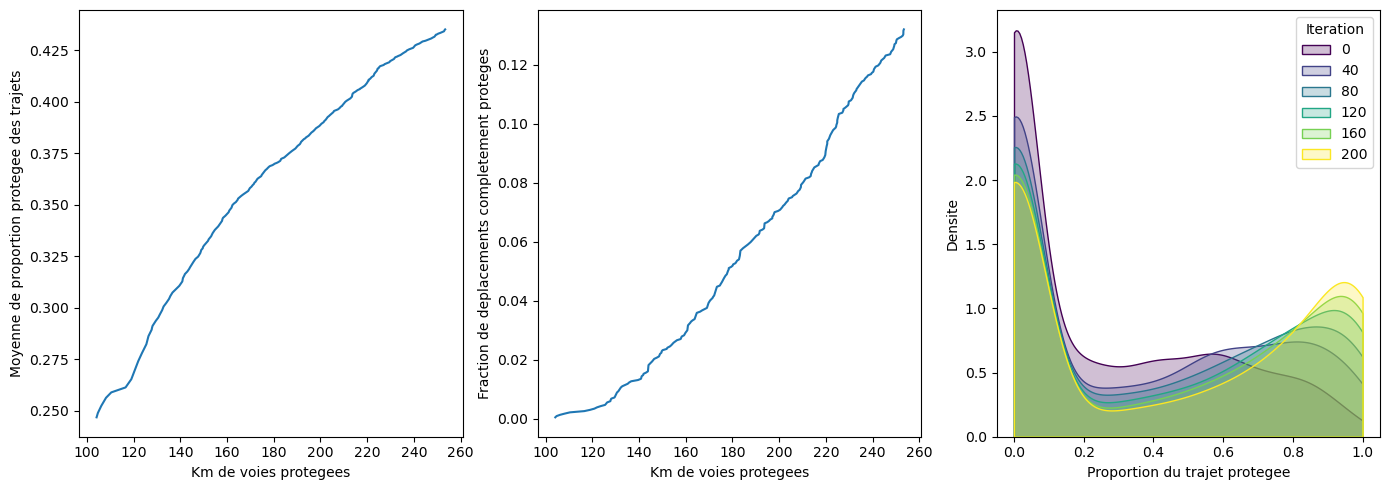

In [93]:
fig, ax = plt.subplots(1,3, figsize = (14,5))
cmap = plt.get_cmap('viridis')
means = []
completes = []
length = np.cumsum(n.n_ex_edges[['length','build_iter']].groupby(by = 'build_iter').sum().values)/1000
for i in range(0,len(n.evol)):
    color = cmap(i / len(n.evol))
    means.append(n.evol[i].mean())
    completes.append(len(n.evol[i][n.evol[i]>0.9999999999999])/len(n.evol[i]))
    if i%(len(n.evol)//5) == 0:
        sns.kdeplot(n.evol[i], cut = 0, fill = 0.3,color = color,ax=ax[2], label = i)

ax[2].legend(title = 'Iteration')
ax[0].plot(length,means)
ax[1].plot(length,completes)
ax[0].set_ylabel('Moyenne de proportion protegee des trajets')
ax[0].set_xlabel('Km de voies protegees')
ax[1].set_xlabel('Km de voies protegees')
ax[0].set_xlabel('Km de voies protegees')
ax[1].set_ylabel('Fraction de deplacements completement proteges')
ax[2].set_xlabel('Proportion du trajet protegee')
ax[2].set_ylabel('Densite')
fig.tight_layout()
fig.savefig('Figures/RVP_evol.png')

In [ ]:
new_network.save('Figures/MTL_1200_it.html')

In [94]:
for i in tqdm(range(0,np.max(n.n_ex_edges.build_iter),5):
    new_network = n.n_ex_edges[n.n_ex_edges.build_iter<=i].explore(column = 'build_iter',style_kwds = {'weight':5})
    img_data = new_network._to_png(1)
    img = Image.open(io.BytesIO(img_data))
    img.save(f'Figures/growth_mtl/growth_{i}.png')


SyntaxError: invalid syntax (2489505290.py, line 1)

In [106]:
path = 'Figures/growth_RVP2/'
filenames = os.listdir(path)
filenames = sorted(filenames, key=lambda x: int(x.split('_')[1].split('.')[0]))
filenames
images = []
for filename in filenames:
    images.append(imageio.imread(path+filename))
imageio.mimsave('Figures/growth_RVP.gif', images ,fps = 15)

C:\Users\latitude\AppData\Local\Temp\ipykernel_7412\3270279784.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path+filename))


  0%|          | 0/200 [00:00<?, ?it/s]

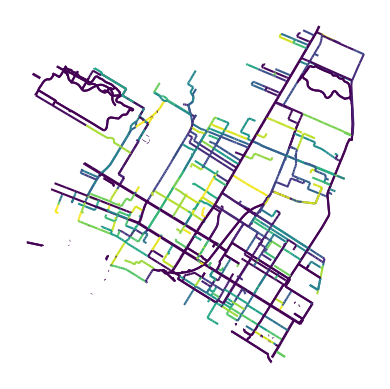

In [105]:
fig, ax = plt.subplots()
ax.axis('off')
for i in tqdm(range(0,np.max(n.n_ex_edges.build_iter))):
    ax.clear()  # Clear the axis
    ax.axis('off')
    n.n_ex_edges[n.n_ex_edges.build_iter<=i].plot(column = 'build_iter',cmap = 'viridis',ax=ax)
    fig.savefig(f'Figures/growth_RVP2/growth_{i}.png')